In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from pymoo.operators.mutation.bitflip import BitflipMutation, Mutation
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.operators.sampling.rnd import BinaryRandomSampling, Sampling
from pymoo.operators.crossover.hux import HUX
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.indicators.hv import Hypervolume
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch

from scipy.stats import ranksums

from joblib import Parallel, delayed
from pathlib import Path
from io import StringIO
import pandas as pd
import numpy as np
import pickle
import os
import re
torch.cuda.is_available()


False

# Function Definitions

In [ ]:
def load_UCI_datasets():
	datasets = [
		(fetch_ucirepo(id=52), "ionosphere"),
		(fetch_ucirepo(id=43), "haberman"),
		(fetch_ucirepo(id=53), "iris0"),
		(fetch_ucirepo(id=42), "glass1"),
		(fetch_ucirepo(id=143), "australia"),
		(fetch_ucirepo(id=277), "thoracic"),
		(fetch_ucirepo(id=50), "segment0"),
		# (fetch_ucirepo(id=149), "vehicle0"),
		(fetch_ucirepo(id=109), "wine"),
		# (fetch_ucirepo(id=39), "ecoli"),
		(fetch_ucirepo(id=225), "ILPD"),
		(fetch_ucirepo(id=45), "heart_disease"),
		(fetch_ucirepo(id=17), "wisconsin"),
		# (fetch_ucirepo(id=73), "mushroom"),
		(fetch_ucirepo(id=94), "spambase"),
		(fetch_ucirepo(id=161), "mammographic"),
		# (fetch_ucirepo(id=12), "balance"),
		(fetch_ucirepo(id=110), "yeast1"),
		(fetch_ucirepo(id=451), "coimbra"),
		(fetch_ucirepo(id=244), "fertility")
	]

	return datasets

def load_KEEL_dataset(path):
	with open(path, 'r') as fh:
		lines = fh.readlines()
	
	relation_name = ''
	attributes = []
	attribute_types = {}
	data_lines = []
	in_data_section = False

	for line in lines:
		line = line.strip()
		if line.startswith('@relation'):
			relation_name = line.split()[1]
		elif line.startswith('@attribute'):
			# Match attribute lines with types and optional ranges or enumerations
			match = re.match(r'@attribute\s+(\w+)\s+(\w+)(?:\s+\[.*?\])?', line)
			if match:
				attr_name, attr_type = match.groups()
				attributes.append(attr_name)
				attribute_types[attr_name] = attr_type
			else:
				# Match attribute lines with enumerated types
				match_enum = re.match(r'@attribute\s+(\w+)\s+\{.*?\}', line)
				if match_enum:
					attr_name = match_enum.group(1)
					attributes.append(attr_name)
					attribute_types[attr_name] = 'categorical'
		elif line.startswith('@data'):
			in_data_section = True
		elif in_data_section:
			if line and not line.startswith('@'):
				data_lines.append(line)

	# Create DataFrame from data lines
	data_str = '\n'.join(data_lines)
	df = pd.read_csv(StringIO(data_str), header=None, names=attributes)

	return df, attribute_types
	# attributes = []
	# attribute_types = {}

	# for line in data_text.split("\n"):
	# 	if line.startswith("@attribute"):
	# 		parts = re.match(r'@attribute (\w+) (real|\{.*\})', line)
	# 		if parts:
	# 			attr_name = parts.group(1)
	# 			attr_type = parts.group(2)
	# 			attributes.append(attr_name)
	# 			attribute_types[attr_name] = attr_type

	# # Extract data section
	# data_section = data_text.split("@data")[1].strip()

	# # Convert data section to DataFrame
	# df = pd.read_csv(StringIO(data_section), header=None, names=attributes)

	# return df, attribute_types

class GenericOptimizer(Problem):
	population_size = 100
	n_neighbours = 5
	sequential = False
	def __init__(self, X_train, y_train, X_val, y_val, objectives, exec_mode):
		self.mutation_history = {}
		self.generation_number = 0

		self.exec_mode = exec_mode

		self.X_train = X_train
		self.y_train = y_train

		self.X_val = X_val
		self.y_val = y_val

		self.training_data = X_train
		self.n_instances = X_train.shape[0]
		
		self.objectives = objectives

		super().__init__(
			n_var=self.n_instances,
			n_obj=len(objectives),               
			n_constr=0,            
			xl=0,                  
			xu=1,                  
			type_var=np.bool_,     
		)

	def _evaluate(self, x, out, *args, **kwargs):
		
		if self.exec_mode == "sequential":
			metrics = []
			for objective in self.objectives:
				metrics.append(self.eval_objective((objective, x)))
		else:
			metrics = Parallel(n_jobs=-1)(delayed(self.eval_objective)((objective, x)) for objective in self.objectives)
		
		self.generation_number += 1

		out["F"] = np.column_stack(metrics)

	def eval_objective(self, pack):
		objective, x = pack
			
		if "calculate_num_examples" in repr(objective):
			return GenericOptimizer.calculate_num_examples(x)

		elif "calculate_IR" in repr(objective):
			vals = []
			for instance in x:
				vals.append(GenericOptimizer.calculate_IR(self.y_train[instance]))
			return vals
		
		else:
			vals = []
			for instance in x:
				vals.append(objective(
					self.X_train[instance],
					self.y_train[instance],
					self.X_val,
					self.y_val,
					GenericOptimizer.n_neighbours
				))
			return vals

	@classmethod
	def calculate_IR(cls, y):
		df = pd.DataFrame(y).value_counts()
		return (df[1]/df[0]) if df.min() == 0 else (df[0]/df[1])
	
	@classmethod
	def filter_by_class(cls, x, y, label):
		indices = np.where(y==label)
		return x[indices], y[indices]
	
	@classmethod
	def calculate_overall_error(cls, x_train, y_train, x_val, y_val, n):
				
		num_included_instances = x_train.shape[0]

		if num_included_instances >= n:
			optimization_knn = KNeighborsClassifier(n_neighbors=n)
			optimization_knn.fit(x_train, y_train)

			y_pred = optimization_knn.predict(x_val)
			balanced_acc = balanced_accuracy_score(y_val, y_pred)
			return 1-balanced_acc
		else:
			return 1

	@classmethod
	def calculate_overall_classBalanced_error(cls, x_train, y_train, x_val, y_val, n):
				
		num_included_instances = x_train.shape[0]

		if num_included_instances >= n:
			optimization_knn = KNeighborsClassifier(n_neighbors=n)
			optimization_knn.fit(x_train, y_train)

			y_pred = optimization_knn.predict(x_val)
			acc = accuracy_score(y_val, y_pred)
			return 1-acc
		else:
			return 1
	
	@classmethod
	def calculate_mean_class_error(cls, x_train, y_train, x_val, y_val, n):
		errors = []
		for label in np.unique(y_val):
			label_x_val, label_y_val = cls.filter_by_class(x_val, y_val, label)
			errors.append(cls.calculate_overall_error(
				x_train,
				y_train,
				label_x_val,
				label_y_val,
				n
			))
		return np.mean(errors)
			
	@classmethod
	def calculate_class0_error(cls, x_train, y_train, x_val, y_val, n):
		class0_x_val, class0_y_val = cls.filter_by_class(x_val, y_val, 0)
		err = cls.calculate_overall_error(
			x_train,
			y_train,
			class0_x_val,
			class0_y_val,
			n
		)
		return err

	@classmethod
	def calculate_class1_error(cls, x_train, y_train, x_val, y_val, n):
		class1_x_val, class1_y_val = cls.filter_by_class(x_val, y_val, 1)
		err = cls.calculate_overall_error(
			x_train,
			y_train,
			class1_x_val,
			class1_y_val,
			n
		)
		return err

	@classmethod
	def calculate_overall_inverse_f1(cls, x_train, y_train, x_val, y_val, n):
				
		num_included_instances = x_train.shape[0]
		counts = pd.DataFrame(y_train).value_counts()
		if num_included_instances >= n:
			optimization_knn = KNeighborsClassifier(n_neighbors=n)
			optimization_knn.fit(x_train, y_train)

			y_pred = optimization_knn.predict(x_val)
			f1 = f1_score(y_val, y_pred, average='binary')
			return 1-f1
		else:
			return 1

	@classmethod
	def calculate_class0_inverse_f1(cls, x_train, y_train, x_val, y_val, n):
		class0_x_val, class0_y_val = cls.filter_by_class(x_val, y_val, 0)
		inv_f1 = cls.calculate_overall_inverse_f1(
			x_train,
			y_train,
			class0_x_val,
			class0_y_val,
			n
		)
		return inv_f1

	@classmethod
	def calculate_class1_inverse_f1(cls, x_train, y_train, x_val, y_val, n):
		class1_x_val, class1_y_val = cls.filter_by_class(x_val, y_val, 1)
		inv_f1 = cls.calculate_overall_inverse_f1(
			x_train,
			y_train,
			class1_x_val,
			class1_y_val,
			n
		)
		return inv_f1
	
	@classmethod
	def calculate_num_examples(cls, instances):
		return np.sum(instances, axis=1)

class DiverseCustomSampling(Sampling):
	def __init__(self):
		super().__init__()

	def _do(self, problem, n_samples, **kwargs):

		target_inclusions = np.random.randint(
			problem.n_var // 3,
			problem.n_var,
			n_samples
		)
		init_pops = []
		for target in target_inclusions:
			array = np.array([1]*target + [0]*(problem.n_var - target))
			np.random.shuffle(array)
			init_pops.append(array)
		init_pops = np.array(init_pops, dtype=np.bool)
		return init_pops

class BiasedBinarySampling(Sampling):
	def __init__(self, labels, major_prob, minor_prob):
		
		self.labels = labels
		counts = pd.DataFrame(labels).value_counts()
		if counts[0] > counts[1]:
			self.c0_thresh = major_prob
			self.c1_thresh = minor_prob
		else:
			self.c0_thresh = minor_prob
			self.c1_thresh = major_prob

		super().__init__()

	def _do(self, problem, n_samples, **kwargs):

		rands = np.random.random((n_samples, problem.n_var))
		init_pops = np.zeros((n_samples, problem.n_var), dtype=bool)
		for idx, label in enumerate(self.labels):
			if label == 0:
				init_pops[:, idx] = (rands[:, idx] < self.c0_thresh).astype(bool)
			if label == 1:
				init_pops[:, idx] = (rands[:, idx] < self.c1_thresh).astype(bool)


		return init_pops
	
def prepare_splits(x, y):
	train_split = StratifiedShuffleSplit(
		n_splits=31, 
		test_size=0.5
	)
	splits = []
	for train_idx, temp_idx in train_split.split(x, y):
		test_split = StratifiedShuffleSplit(
			n_splits=1, 
			test_size=0.5
		)
		test_idx, validation_idx = next(test_split.split(x[temp_idx], y[temp_idx]))

		validation_idx = temp_idx[validation_idx]
		test_idx = temp_idx[test_idx]
		
		splits.append((train_idx, validation_idx, test_idx))
	return splits

def create_UCI_preprocessor_pipeline(variables):
	
	type_mappings = {}
	for variable_idx, variable_name in enumerate(variables['name']):
		variable_type = variables['type'][variable_idx]
		if variable_type not in type_mappings:
			type_mappings[variable_type] = []

		if variables['role'][variable_idx] == 'Feature':
			type_mappings[variable_type].append(variable_name)

	categorical_transformer = Pipeline(steps=[
		('imputer', SimpleImputer(strategy='most_frequent')),
		('onehot', OneHotEncoder(handle_unknown='ignore'))
	])
	numerical_transformer = Pipeline(steps=[
		('imputer', SimpleImputer(strategy='mean')),
		('scaler', StandardScaler())
	])

	numerical_features = []
	if 'Continuous' in type_mappings:
		for feature in type_mappings['Continuous']:
			numerical_features.append(feature)
	if 'Integer' in type_mappings:
		for feature in type_mappings['Integer']:
			numerical_features.append(feature)
			
	transformer_steps = []
	if numerical_features != []:
		transformer_steps.append(
			('num', numerical_transformer, numerical_features)
		)
	if 'Categorical' in type_mappings:
		transformer_steps.append(
			('cat', categorical_transformer, type_mappings['Categorical'])
		)
	preprocessor = ColumnTransformer(
		transformers=transformer_steps
	)
	pipeline = Pipeline(steps=[
		('preprocessor', preprocessor)
	])
	
	return pipeline

	type_mappings = {}
	categorical_features = []
	numerical_features = []

	for column in attributes:
		if column != "Class" and attributes[column] != 'categorical':
			numerical_features.append(column)
		elif column != "Class" and attributes[column] == 'categorical':
			categorical_features.append(column)
	y = dataset['Class']	
	X = dataset.drop(columns=['Class'], inplace=True)

	label_encoder = LabelEncoder()
	y = label_encoder.fit_transform(y)

	categorical_transformer = Pipeline(steps=[
		('imputer', SimpleImputer(strategy='most_frequent')),
		('onehot', OneHotEncoder(handle_unknown='ignore'))
	])
	numerical_transformer = Pipeline(steps=[
		('imputer', SimpleImputer(strategy='mean')),
		('scaler', StandardScaler())
	])

	numerical_features = []
	if 'Continuous' in type_mappings:
		for feature in type_mappings['Continuous']:
			numerical_features.append(feature)
	if 'Integer' in type_mappings:
		for feature in type_mappings['Integer']:
			numerical_features.append(feature)
			
	transformer_steps = []
	if numerical_features != []:
		transformer_steps.append(
			('num', numerical_transformer, numerical_features)
		)
	if 'Categorical' in type_mappings:
		transformer_steps.append(
			('cat', categorical_transformer, categorical_features)
		)
	preprocessor = ColumnTransformer(
		transformers=transformer_steps
	)
	pipeline = Pipeline(steps=[
		('preprocessor', preprocessor)
	])

	return pipeline

def create_KEEL_preprocessor_pipeline(attributes):
	type_mappings = {}
	categorical_features = []
	numerical_features = []

	for column in attributes:
		if column != "Class" and attributes[column] != 'categorical':
			numerical_features.append(column)
		elif column != "Class" and attributes[column] == 'categorical':
			categorical_features.append(column)

	categorical_transformer = Pipeline(steps=[
		('imputer', SimpleImputer(strategy='most_frequent')),
		('onehot', OneHotEncoder(handle_unknown='ignore'))
	])
	numerical_transformer = Pipeline(steps=[
		('imputer', SimpleImputer(strategy='mean')),
		('scaler', StandardScaler())
	])
			
	transformer_steps = []
	if numerical_features != []:
		transformer_steps.append(
			('num', numerical_transformer, numerical_features)
		)
	if 'Categorical' in type_mappings:
		transformer_steps.append(
			('cat', categorical_transformer, categorical_features)
		)
	preprocessor = ColumnTransformer(
		transformers=transformer_steps
	)
	pipeline = Pipeline(steps=[
		('preprocessor', preprocessor)
	])

	return pipeline

def over_sample(x, y):
	counts = pd.DataFrame(y).value_counts()
	minority_class_label = counts.index[np.argmin(counts)][0]
	minority_class_indicies = np.where(y == minority_class_label)[0]
	# y = y.reshape(-1, 1)
	over_sampled_x = np.concatenate((x, x[minority_class_indicies]), axis=0)
	over_sampled_y = np.concatenate((y, y[minority_class_indicies]), axis=0)
	# over_sampled_y = over_sampled_y.reshape(-1)    
	return over_sampled_x, over_sampled_y

def parallel_error(instance, x_train, y_train, x_compare, y_compare):

	x_filtered, y_filtered = x_train[instance], y_train[instance]
	if x_filtered.shape[0] < GenericOptimizer.n_neighbours: 
		error = 1
	else:
		knn = KNeighborsClassifier(n_neighbors=GenericOptimizer.n_neighbours)
		knn.fit(x_filtered, y_filtered)
		y_pred = knn.predict(x_compare)
		error = 1 - accuracy_score(y_compare, y_pred)
	return error

def calculate_metrics(x_train, y_train, x_validation, y_validation, x_test, y_test, result):
	baseline_validation_err = GenericOptimizer.calculate_overall_error(
		x_train, y_train,
		x_validation, y_validation,
		GenericOptimizer.n_neighbours
	)
	baseline_test_err = GenericOptimizer.calculate_overall_error(
		x_train, y_train,
		x_test, y_test,
		GenericOptimizer.n_neighbours
	)


	result_pareto_front = result.X
	if len(result_pareto_front.shape) == 1:
		result_pareto_front = np.array([result_pareto_front])

	validation_F = Parallel(n_jobs=-1)(delayed(parallel_error)(instance, x_train, y_train, x_validation, y_validation) for instance in result_pareto_front)
	ideal_validation = result_pareto_front[np.argmin(validation_F)]
	validation_inclusions = np.sum(ideal_validation)
	optimized_validation_err = GenericOptimizer.calculate_overall_error(
		x_train[ideal_validation],
		y_train[ideal_validation],
		x_validation,
		y_validation,
		GenericOptimizer.n_neighbours
	)
	optimized_test_err = GenericOptimizer.calculate_overall_error(
		x_train[ideal_validation],
		y_train[ideal_validation],
		x_test,
		y_test,
		GenericOptimizer.n_neighbours
	)

	test_F = Parallel(n_jobs=-1)(delayed(parallel_error)(instance, x_train, y_train, x_test, y_test) for instance in result_pareto_front)
	ideal_test = result_pareto_front[np.argmin(test_F)]
	test_inclusions = np.sum(ideal_test)
	ideal_optimized_test_err = GenericOptimizer.calculate_overall_error(
		x_train[ideal_test],
		y_train[ideal_test],
		x_test,
		y_test,
		GenericOptimizer.n_neighbours
	)
	return validation_inclusions, test_inclusions, baseline_validation_err, baseline_test_err, optimized_validation_err, optimized_test_err, ideal_optimized_test_err

# AE Minority example synthesis

In [ ]:

class CustomMutation(Mutation):
	curr_MLP = None
	num_synthetic_examples = 500000
	train_epochs = 50
	batch_size = 215
	primary_objective = GenericOptimizer.calculate_overall_error


	def __init__(self, x_train, y_train, x_validation, y_validation, prediction_threshold=0.5):
		super().__init__()
		self.prediction_thresh = prediction_threshold
		synthesized_x, synthesized_y = CustomMutation.create_training_data(x_train, y_train, x_validation, y_validation)
		self.model = CustomMutation.train_mutation(synthesized_x, synthesized_y)

	def _do(self, problem, X, **kwargs):

		int_x = np.array(X, dtype=np.float32)
		dataset = CustomDataset(int_x, int_x)
		loader = DataLoader(dataset, batch_size=X.shape[0], shuffle=False)

		self.model.eval()
		with torch.no_grad():
			for data, _ in loader:
				data = data.to(CustomMutation.device)
				outputs = self.model(data)
				predictions = (outputs > self.prediction_thresh).bool()

		prediction = np.array(predictions)

		total_number_of_genes = X.shape[0] * X.shape[1]
		genes_effected = np.sum(X ^ prediction)

		if problem.generation_number not in problem.mutation_history:
			problem.mutation_history[problem.generation_number] = []
		
		problem.mutation_history[problem.generation_number].append(genes_effected/total_number_of_genes)
		return prediction

	@classmethod
	def train_mutation(cls, x_train, y_train):
		train_set = CustomDataset(x_train, y_train)
		input_dim = x_train.shape[1]
		batch_size = cls.batch_size
		train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

		device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

		 
		model = MLP(input_dim).to(device)
		optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
		criterion = nn.BCEWithLogitsLoss()

		model.train()
		for epoch in range(cls.train_epochs):
			losses = []
			for batch_num, input_data in enumerate(train_loader):
				optimizer.zero_grad()
				x, y = input_data
				x, y = x.to(device).float(), y.to(device)

				output = model(x)
				loss = criterion(output, y)
				loss.backward()
				losses.append(loss.item())
				optimizer.step()

		return model
	
	@classmethod
	def create_training_data(cls, x_train, y_train, x_validation, y_validation):
		
		synthesizing_splits = StratifiedShuffleSplit(
			n_splits=len(cls.secondary_objectives), # create a split for each secondary objective
			test_size=0.5, # Half the validation set is randomly excluded
		)	
		packages = []
		for idx, (sub_validation_idx, _) in enumerate(synthesizing_splits.split(x_validation, y_validation)):
			packages.append((
				cls.secondary_objectives[idx],
				x_train,
				y_train,
				x_validation[sub_validation_idx],
				y_validation[sub_validation_idx]
			))

		# Execute optimization and extract the final populations
		populations = Parallel(n_jobs=-1)(delayed(cls.execute_training_data_gen)(package) for package in packages)
		
		# Aggregate all populations into single list containing every unique instance
		all_instances = []
		for population in populations:
			for individual in population.pop:
				all_instances.append(list(individual.X))
				
		all_instances = np.array(all_instances)

		# Create synthetic examples by adding randin noise to each instance. Repeat until threshold is reached.
		synthetic_x, synthetic_y = [], []
		while len(synthetic_x) < cls.num_synthetic_examples:
			
			for y_true in all_instances:
				x_noised = []
				for idx, probability in enumerate(np.random.uniform(0.1, 1.0, y_true.shape[0])):
					if probability < 0.85:
						x_noised.append(y_true[idx])                
					else:
						x_noised.append(0 if y_true[idx] == 1 else 1)

				synthetic_x.append(np.array(x_noised, dtype=np.float32))
				synthetic_y.append(np.array(y_true, dtype=np.float32))

		return np.array(synthetic_x), np.array(synthetic_y)
	
	@classmethod
	def execute_training_data_gen(cls, package):

		objectives, x_train, y_train, x_validation, y_validation = package
		
		objectives.append(cls.primary_objective)

		problem = GenericOptimizer(
			x_train, 
			y_train, 
			x_validation, 
			y_validation,
			objectives,
			"Sequential"
		)

		algorithm = NSGA2(
			pop_size=GenericOptimizer.population_size, 
			sampling=BinaryRandomSampling(), 
			crossover=HUX(), 
			mutation=BitflipMutation(), 
			eliminate_duplicates=True
		)
		result = minimize(
			problem, 
			algorithm, 
			('n_gen', GenericOptimizer.population_size)
		)
		
		return result

## Create noised examples using features of training set

In [73]:
dataset = list(data_mapper.keys())[300]

x_train = data_mapper[dataset]["x_train"]
y_train = data_mapper[dataset]["y_train"]

x_validation = data_mapper[dataset]["x_validation"]
y_validation = data_mapper[dataset]["y_validation"]


knn1 = KNeighborsClassifier(n_neighbors=5)
knn1.fit(x_train, y_train)
y_pred = knn1.predict(x_validation)
accuracy = accuracy_score(y_validation, y_pred)
print(accuracy)


counts = pd.DataFrame(y_train).value_counts()
minority_class_label = counts.index[np.argmin(counts)][0]
minority_class_indicies = np.where(y_train == minority_class_label)[0]

feature_statistics = []
variance = np.var(x_train[minority_class_indicies], axis=0)
noising_range = variance

# Create synthetic examples by adding randin noise to each instance. Repeat until threshold is reached.
synthetic_x, synthetic_y = [], []
original_x = []
while len(synthetic_x) < 10000:
	for minority_idx in minority_class_indicies:

		x_true = x_train[minority_idx]
		x_noised = []

		for idx, feature in enumerate(x_true):
			noise = np.random.uniform(-noising_range[idx], noising_range[idx])
			x_noised.append(feature + noise)
	
		synthetic_x.append(x_noised)
		original_x.append(x_true)
		synthetic_y.append(minority_class_label)

synthetic_x = np.array(synthetic_x)
synthetic_y = np.array(synthetic_y)
original_x = np.array(original_x)
synthetic_x.shape

0.7547169811320755


(10044, 18)

# Train AE to predict the no-noise example corresponding to the noised synthetic example

In [74]:
class MLP(nn.Module):
	def __init__(self, input_dim):
		super(MLP, self).__init__()
		self.linear1 = nn.Linear(input_dim, input_dim//2)
		self.relu1 = nn.ReLU()
		self.linear2 = nn.Linear(input_dim//2, input_dim//3)
		self.relu2 = nn.ReLU()
		self.linear3 = nn.Linear(input_dim//3, input_dim)

	def forward(self, x):
		x = self.linear1(x)
		x = self.relu1(x)
		x = self.linear2(x)
		x = self.relu2(x)
		x = self.linear3(x)
		return x
	
class CustomDataset(Dataset):
	def __init__(self, x_synthetic, x_true):
		self.x = x_synthetic
		self.y = x_true
	def __len__(self):
		return self.x.shape[0]
	def __getitem__(self, ind):
		x = self.x[ind]
		y = self.y[ind]
		return x, y

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_set = CustomDataset(synthetic_x, original_x)
input_dim = synthetic_x[0].shape[0]
batch_size = 5
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

model = MLP(input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
criterion = nn.BCEWithLogitsLoss()

model.train()
for epoch in range(100):
	losses = []
	for batch_num, input_data in enumerate(train_loader):
		optimizer.zero_grad()
		x, y = input_data
		x, y = x.to(device).float(), y.to(device)

		output = model(x)
		loss = criterion(output, y)
		loss.backward()
		losses.append(loss.item())
		optimizer.step()

	avg_loss = sum(losses) / len(losses)
	print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")


Epoch 1, Average Loss: 0.7521
Epoch 2, Average Loss: 0.7486
Epoch 3, Average Loss: 0.7451
Epoch 4, Average Loss: 0.7417
Epoch 5, Average Loss: 0.7383
Epoch 6, Average Loss: 0.7349
Epoch 7, Average Loss: 0.7316
Epoch 8, Average Loss: 0.7283
Epoch 9, Average Loss: 0.7250
Epoch 10, Average Loss: 0.7217
Epoch 11, Average Loss: 0.7184
Epoch 12, Average Loss: 0.7152
Epoch 13, Average Loss: 0.7119
Epoch 14, Average Loss: 0.7086
Epoch 15, Average Loss: 0.7054
Epoch 16, Average Loss: 0.7021
Epoch 17, Average Loss: 0.6988
Epoch 18, Average Loss: 0.6955
Epoch 19, Average Loss: 0.6922
Epoch 20, Average Loss: 0.6888
Epoch 21, Average Loss: 0.6854
Epoch 22, Average Loss: 0.6820
Epoch 23, Average Loss: 0.6785
Epoch 24, Average Loss: 0.6750
Epoch 25, Average Loss: 0.6714
Epoch 26, Average Loss: 0.6678
Epoch 27, Average Loss: 0.6642
Epoch 28, Average Loss: 0.6604
Epoch 29, Average Loss: 0.6566
Epoch 30, Average Loss: 0.6528
Epoch 31, Average Loss: 0.6488
Epoch 32, Average Loss: 0.6448
Epoch 33, Average

## Excute inference on the minority examples of the validation set until stopping condition

In [75]:
x_input_set = x_train
y_input_set = y_train

counts = pd.DataFrame(y_input_set).value_counts()
minority_class_label = counts.index[np.argmin(counts)][0]
minority_class_indicies = np.where(y_input_set == minority_class_label)[0]
minority_examples = x_input_set[minority_class_indicies]

dataset = CustomDataset(minority_examples, minority_examples)
loader = DataLoader(dataset, batch_size=len(minority_examples), shuffle=False)


# dataset = CustomDataset(x_train, x_train)
# loader = DataLoader(dataset, batch_size=len(x_train), shuffle=False)

model.eval()
with torch.no_grad():
	for data, _ in loader:
		data = data.to(device).float()
		outputs = model(data)
outputs.cpu()


knn1 = KNeighborsClassifier(n_neighbors=5)
knn1.fit(x_train, y_train)
y_pred = knn1.predict(x_validation)
accuracy = accuracy_score(y_validation, y_pred)
print(accuracy)


x_combine = np.concatenate([x_train, outputs])
y_combine = np.concatenate([y_train, [minority_class_label] * len(outputs)])

print(x_train.shape)
print(y_train.shape)
print(outputs.shape)
print(x_combine.shape)
print(y_combine.shape)
knn2 = KNeighborsClassifier(n_neighbors=5)
knn2.fit(x_combine, y_combine)
y_pred = knn2.predict(x_validation)
accuracy = accuracy_score(y_validation, y_pred)
print(accuracy)

0.7547169811320755
(423, 18)
(423,)
torch.Size([108, 18])
(531, 18)
(531,)
0.7452830188679245


In [86]:
minority_examples[0]

array([-1.41908213, -1.43713733, -1.97235381, -1.64236071, -1.1027788 ,
       -0.99323245, -1.01847746,  1.16129905, -0.99696459, -1.51642047,
       -1.23103504, -0.97351574, -0.94392582,  1.80925339,  1.75425237,
       -0.96340232, -1.28769984, -1.83369045])

In [88]:
f1 = []
for sample in outputs:
    ar = np.array(sample)
    f1.append(ar[0])

C:\Users\RjKim\AppData\Local\Temp\ipykernel_22124\1534016298.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  ar = np.array(sample)


In [90]:
ff1 = []
for sample in minority_examples:
    ar = np.array(sample)
    ff1.append(ar[0])

In [95]:
print("Min ", np.min(ff1))
print("Median ", np.median(ff1))
print("Mean ", np.mean(ff1))
print("Max ", np.max(ff1))

Min  -1.9051321290379621
Median  0.40360534398346526
Mean  0.5329936526566933
Max  2.8338553155849677


In [94]:
print("Min ", np.min(f1))
print("Median ", np.median(f1))
print("Mean ", np.mean(f1))
print("Max ", np.max(f1))

Min  -0.13272879
Median  0.15426266
Mean  0.11608129
Max  0.4343503


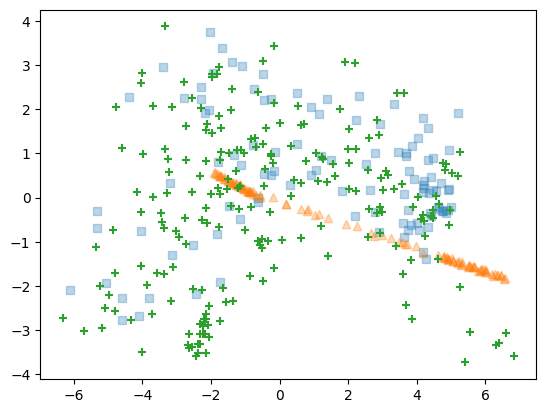

<Figure size 800x600 with 0 Axes>

In [76]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

train_pca = pca.fit_transform(x_train)
min_train = pca.transform(minority_examples)

# Step 2: Apply PCA transform to the other sets
# augmented_pca = pca.transform(x_combine)
augmented_pca = pca.transform(outputs)
validation_pca = pca.transform(x_validation)

plt.scatter(min_train[:,0], min_train[:,1], marker='s', alpha=0.3)
# plt.scatter(train_pca[:,0], train_pca[:,1], marker='o', alpha=0.3)
plt.scatter(augmented_pca[:,0], augmented_pca[:,1], marker='^', alpha=0.3)
plt.scatter(validation_pca[:,0], validation_pca[:,1], marker='+')


# Step 4: Plot with color-coded labels
plt.figure(figsize=(8, 6))
plt.show()

# Create data packages

In [3]:
objectives_sets = [
	# [GenericOptimizer.calculate_overall_error, GenericOptimizer.calculate_num_examples],
	[GenericOptimizer.calculate_class0_error, GenericOptimizer.calculate_class1_error],
	# [GenericOptimizer.calculate_overall_classBalanced_error],
	# [GenericOptimizer.calculate_mean_class_error]
]

# packages = []
# data_mapper = {}
datasets = []
for dat_file in Path('datasets').rglob('*.dat'):

	name = str(dat_file.name).replace(".dat", "")
	datasets.append(name)
# 	dataset, attributes = load_KEEL_dataset(dat_file)

# 	y = dataset['Class']	
# 	raw_X = dataset.drop(columns=['Class'])
	
# 	label_encoder = LabelEncoder()
# 	y = label_encoder.fit_transform(y)

# 	pipeline = create_KEEL_preprocessor_pipeline(attributes)

# 	pipeline.fit(raw_X, y)
# 	X = pipeline.transform(raw_X)
# 	label_encoder = LabelEncoder()
# 	y = label_encoder.fit_transform(y)

# 	for c, (train_idx, validation_idx, test_idx) in enumerate(prepare_splits(X, y)):
# 		for objectives in objectives_sets:
			
# 			data_mapper[f"{c}_{name}"] = {
# 				'x_train': X[train_idx],
# 				'y_train': y[train_idx],
# 				'x_validation': X[validation_idx],
# 				'y_validation': y[validation_idx],
# 				'x_test':X[test_idx],
# 				'y_test': y[test_idx],
# 			}

# with open('data.pickle', 'wb') as fh:
# 	pickle.dump(data_mapper, fh)
with open('data.pickle', 'rb') as fh:
	data_mapper = pickle.load(fh)


# Executions

In [17]:
def func(package):
	
	data_key, objectives = package
	objectives_names = '_'.join([re.search(r'\.([a-zA-Z_][a-zA-Z0-9_]*)\s', str(objective_name)).group(1) for objective_name in objectives])

	if os.path.exists(f"results/{data_key} randPopulation {objectives_names}.pickle"):
		return None, data_key
				   
	problem = GenericOptimizer(
		data_mapper[data_key]['x_train'], 
		data_mapper[data_key]['y_train'], 
		data_mapper[data_key]['x_validation'], 
		data_mapper[data_key]['y_validation'], 
		objectives,
		"sequential"
	)
	algorithm = NSGA2(
		pop_size=GenericOptimizer.population_size, 
		sampling=BinaryRandomSampling(), # <----- POPULATION
		crossover=HUX(), 
		mutation=BitflipMutation(), 
		eliminate_duplicates=True,
	)
	result = minimize(
		problem, 
		algorithm, 
		('n_gen', GenericOptimizer.population_size),
		save_history=False
	)
	return result, data_key

for objectives in objectives_sets:
	for result, data_key in Parallel(n_jobs=-1)(delayed(func)((data_key, objectives)) for data_key in data_mapper):

		if result is None:
			print(f"Passed on {data_key}")
		
		else:
			objectives_names = '_'.join([re.search(r'\.([a-zA-Z_][a-zA-Z0-9_]*)\s', str(objective_name)).group(1) for objective_name in objectives])

			with open(os.path.join("results", f'{data_key} randPopulation {objectives_names}.pickle'), 'wb') as fh:
				pickle.dump(result, fh)

In [18]:
def func(package):
	data_key, objectives = package

	if os.path.exists(f"results/{data_key} diversePopulation {objectives_names}.pickle"):
		return None, data_key
				   
	problem = GenericOptimizer(
		data_mapper[data_key]['x_train'], 
		data_mapper[data_key]['y_train'], 
		data_mapper[data_key]['x_validation'], 
		data_mapper[data_key]['y_validation'], 
		objectives,
		"sequential"
	)
	algorithm = NSGA2(
		pop_size=GenericOptimizer.population_size, 
		sampling=DiverseCustomSampling(), # <----- POPULATION
		crossover=HUX(), 
		mutation=BitflipMutation(), 
		eliminate_duplicates=True,
	)
	result = minimize(
		problem, 
		algorithm, 
		('n_gen', GenericOptimizer.population_size),
		save_history=False
	)
	return result, data_key

for objectives in objectives_sets:
	for result, data_key in Parallel(n_jobs=-1)(delayed(func)((data_key, objectives)) for data_key in data_mapper):
		objectives_names = '_'.join([re.search(r'\.([a-zA-Z_][a-zA-Z0-9_]*)\s', str(objective_name)).group(1) for objective_name in objectives])

		if result is None:
			print(f"Passed on {data_key}")
		
		else:
			objectives_names = '_'.join([re.search(r'\.([a-zA-Z_][a-zA-Z0-9_]*)\s', str(objective_name)).group(1) for objective_name in objectives])

			with open(os.path.join("results", f'{data_key} diversePopulation {objectives_names}.pickle'), 'wb') as fh:
				pickle.dump(result, fh)

# Newest

In [4]:
def func0(data_key):

	if any(dataset_name in data_key for dataset_name in datasets[:4]) is False:
		return None, data_key
	objectives = [GenericOptimizer.calculate_class0_error, GenericOptimizer.calculate_class1_error]
	objectives_names = '_'.join([re.search(r'\.([a-zA-Z_][a-zA-Z0-9_]*)\s', str(objective_name)).group(1) for objective_name in objectives])
	if os.path.exists(f"results/{data_key} diversePopulationHIST {objectives_names}.pickle"):
		return None, data_key

	problem = GenericOptimizer(
		data_mapper[data_key]['x_train'], 
		data_mapper[data_key]['y_train'], 
		data_mapper[data_key]['x_validation'], 
		data_mapper[data_key]['y_validation'], 
		[GenericOptimizer.calculate_class0_error, GenericOptimizer.calculate_class1_error],
		"parallel"
	)
	algorithm = NSGA2(
		pop_size=GenericOptimizer.population_size, 
		sampling=DiverseCustomSampling(), # <----- POPULATION
		crossover=HUX(), 
		mutation=BitflipMutation(), 
		eliminate_duplicates=True,
	)
	result = minimize(
		problem, 
		algorithm, 
		('n_gen', GenericOptimizer.population_size),
		save_history=True
	)
	return result, data_key

def func1(data_key):
	if any(dataset_name in data_key for dataset_name in datasets[:4]) is False:
		return None, data_key
	objectives = [GenericOptimizer.calculate_class0_error, GenericOptimizer.calculate_class1_error]
	objectives_names = '_'.join([re.search(r'\.([a-zA-Z_][a-zA-Z0-9_]*)\s', str(objective_name)).group(1) for objective_name in objectives])
	if os.path.exists(f"results/{data_key} randPopulationHIST {objectives_names}.pickle"):
		return None, data_key

	problem = GenericOptimizer(
		data_mapper[data_key]['x_train'], 
		data_mapper[data_key]['y_train'], 
		data_mapper[data_key]['x_validation'], 
		data_mapper[data_key]['y_validation'], 
		[GenericOptimizer.calculate_class0_error, GenericOptimizer.calculate_class1_error],
		"parallel"
	)
	algorithm = NSGA2(
		pop_size=GenericOptimizer.population_size, 
		sampling=BinaryRandomSampling(), # <----- POPULATION
		crossover=HUX(), 
		mutation=BitflipMutation(), 
		eliminate_duplicates=True,
	)
	result = minimize(
		problem, 
		algorithm, 
		('n_gen', GenericOptimizer.population_size),
		save_history=True
	)
	return result, data_key

def func2(data_key):
	if any(dataset_name in data_key for dataset_name in datasets[:4]) is False:
		return None, data_key
	objectives = [GenericOptimizer.calculate_class0_error, GenericOptimizer.calculate_class1_error]
	objectives_names = '_'.join([re.search(r'\.([a-zA-Z_][a-zA-Z0-9_]*)\s', str(objective_name)).group(1) for objective_name in objectives])
	if os.path.exists(f"results/{data_key} biasPopulationHIST {objectives_names}.pickle"):
		return None, data_key

	problem = GenericOptimizer(
		data_mapper[data_key]['x_train'], 
		data_mapper[data_key]['y_train'], 
		data_mapper[data_key]['x_validation'], 
		data_mapper[data_key]['y_validation'], 
		[GenericOptimizer.calculate_class0_error, GenericOptimizer.calculate_class1_error],
		"parallel"
	)
	algorithm = NSGA2(
		pop_size=GenericOptimizer.population_size, 
		sampling=BiasedBinarySampling(y_train, 0.4, 0.7), # <----- POPULATION
		crossover=HUX(), 
		mutation=BitflipMutation(), 
		eliminate_duplicates=True,
	)
	result = minimize(
		problem, 
		algorithm, 
		('n_gen', GenericOptimizer.population_size),
		save_history=True
	)
	return result, data_key

objectives = [GenericOptimizer.calculate_class0_error, GenericOptimizer.calculate_class1_error]
objectives_names = '_'.join([re.search(r'\.([a-zA-Z_][a-zA-Z0-9_]*)\s', str(objective_name)).group(1) for objective_name in objectives])
num_jobs = 4
for _ in range(10):
	try:

		for result, data_key in Parallel(n_jobs=num_jobs)(delayed(func0)(data_key) for data_key in data_mapper):
			if result is None: print(f"Passed on {data_key}")	
			else:				
				with open(os.path.join("results", f'{data_key} diversePopulationHIST {objectives_names}.pickle'), 'wb') as fh:
					print(f'Save > {data_key} diversePopulationHIST {objectives_names}.pickle')
					pickle.dump(result, fh)
		break
	except Exception as E:
		import time
		print(E)
		time.sleep(100)

for _ in range(10):
	try:
		for result, data_key in Parallel(n_jobs=num_jobs)(delayed(func1)(data_key) for data_key in data_mapper):
			if result is None: print(f"Passed on {data_key}")	
			else:				
				with open(os.path.join("results", f'{data_key} randPopulationHIST {objectives_names}.pickle'), 'wb') as fh:
					print(f"f'Saved > {data_key} randPopulationHIST {objectives_names}.pickle'")
					pickle.dump(result, fh)
		break
	
	except:
		import time
		time.sleep(100)

for _ in range(10):
	try:
		for result, data_key in Parallel(n_jobs=num_jobs)(delayed(func2)(data_key) for data_key in data_mapper):
			if result is None: print(f"Passed on {data_key}")	
			else:				
				with open(os.path.join("results", f'{data_key} biasPopulationHIST {objectives_names}.pickle'), 'wb') as fh:
					print(f'Saved > {data_key} biasPopulationHIST {objectives_names}.pickle')
					pickle.dump(result, fh)

		break
	except:
		import time
		time.sleep(100)


Save > 0_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle
Save > 1_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle
Save > 2_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle
Save > 3_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle
Save > 4_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle
Save > 5_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle
Save > 6_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle
Save > 7_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle
Save > 8_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle
Save > 9_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle
Save > 10_abalone9-18 diversePopulationH

In [5]:
scheme_map = {}
for file in os.listdir("results"):    
	if 'HIST' in file:
		name = file.replace(".pickle", "")
		segments = name.split(" ")
		dataset_name = "_".join(segments[0].split("_")[1:])
		
		exec_name = f"{dataset_name} {segments[1]} {segments[2]}"

		if exec_name not in scheme_map:
			scheme_map[exec_name] = []
		
		scheme_map[exec_name].append(file)

for scheme in scheme_map:
	for exec in scheme_map[scheme]:

		with open(f"results\\{exec}", 'rb') as fh:
			results = pickle.load(fh)

		init_pop = results.history[0].pop.get("X")
		last_pop = results.history[-1].pop.get("X")
		
		sums = np.sum(last_pop, axis=1)

		print("\n-------------------------------------\n")
		print(f"{exec}\n")
		print(f"Max possible size of an individual: {init_pop.shape[1]}\n")

		print(f"Individuals generated using range: {init_pop.shape[1]//3} - {init_pop.shape[1]}\n")
		print(f"Summary stats:")
		print(f"\t - Min: {np.min(sums)}")
		print(f"\t - Median: {np.median(sums)}")
		print(f"\t - Mean: {np.mean(sums)}")
		print(f"\t - Max: {np.max(sums)}\n")

		print(f"Number of selected sampled for every individual: \n{sums}")
		print("\n-------------------------------------\n")
		
		break
	break


-------------------------------------

0_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle

Max possible size of an individual: 365

Individuals generated using range: 121 - 365

Summary stats:
	 - Min: 252
	 - Median: 268.5
	 - Mean: 268.25
	 - Max: 288

Number of selected sampled for every individual: 
[281 283 271 271 267 259 272 252 256 264 268 262 269 267 274 277 271 276
 271 267 270 256 268 269 257 274 259 267 272 259 272 261 275 273 265 272
 270 270 260 264 273 265 262 264 267 268 271 266 276 280 257 277 277 265
 273 272 269 271 279 288 271 261 276 262 268 258 281 268 271 272 262 262
 263 260 265 264 272 272 267 267 280 260 263 280 260 269 264 262 270 259
 274 264 264 265 270 270 272 259 274 273]

-------------------------------------



In [6]:
for scheme in scheme_map:
	for exec in scheme_map[scheme]:

		if "rand" in scheme:
			continue
		
		print(scheme)
		with open(f"results\\{exec}", 'rb') as fh:
			results = pickle.load(fh)

		init_pop = results.history[0].pop.get("X")
		last_pop = results.history[-1].pop.get("X")
		rand_pop1 = results.history[98].pop.get("X")
		rand_pop2 = results.history[46].pop.get("X")
		
		break

	

init_pop
# for individual in rand_pop2:
# 	print(individual)

abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error
ecoli-0-1-3-7_vs_2-6 diversePopulationHIST calculate_class0_error_calculate_class1_error
ecoli4 diversePopulationHIST calculate_class0_error_calculate_class1_error
glass2 diversePopulationHIST calculate_class0_error_calculate_class1_error


array([[ True, False, False, ...,  True,  True,  True],
       [False,  True, False, ..., False, False,  True],
       [False,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True, False, ..., False, False,  True],
       [False, False, False, ...,  True,  True, False]], shape=(100, 107))

In [ ]:
# pd.DataFrame(init_pop).value_counts()

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  200  201  202  203  204  205  206  207  208  209  210  211  212  213  214  215  216  217  218  219  220  221  

In [10]:
scheme_map = {}
for file in os.listdir("results"):    
	if 'HIST' in file:
		name = file.replace(".pickle", "")
		segments = name.split(" ")
		dataset_name = "_".join(segments[0].split("_")[1:])
		
		exec_name = f"{dataset_name} {segments[1]} {segments[2]}"

		if exec_name not in scheme_map:
			scheme_map[exec_name] = []
		
		scheme_map[exec_name].append(file)

min_records = []
max_records = []
mean_records = []
median_records = []

for scheme in scheme_map:
	mins = []
	medians = []
	means = []
	maxes = []
	dataset_name = scheme.split(" ")[0]
	sample_type = scheme.split(" ")[1].replace("HIST", "")
	for exec in scheme_map[scheme]:

		with open(f"results\\{exec}", 'rb') as fh:
			results = pickle.load(fh)

		init_pop = results.history[0].pop.get("X")
		last_pop = results.history[-1].pop.get("X")
		
		sums = np.sum(init_pop, axis=1)
		num_samples = init_pop.shape[1]
		mins.append(np.min(sums))
		medians.append(np.median(sums))
		means.append(np.mean(sums))
		maxes.append(np.max(sums))

	min_records.append({
		"Scheme": f"{dataset_name} {sample_type}",
		"Total Samples": num_samples,
		"Min": np.max(mins),
		"Median": np.median(mins),
		"Mean": np.mean(mins),
		"Max": np.max(mins)
	})

	max_records.append({
		"Scheme": f"{dataset_name} {sample_type}",
		"Total Samples": num_samples,
		"Min": np.max(maxes),
		"Median": np.median(maxes),
		"Mean": np.mean(maxes),
		"Max": np.max(maxes)
	})


	mean_records.append({
		"Scheme": f"{dataset_name} {sample_type}",
		"Total Samples": num_samples,
		"Min": np.max(means),
		"Median": np.median(means),
		"Mean": np.mean(means),
		"Max": np.max(means)
	})

	median_records.append({
		"Scheme": f"{dataset_name} {sample_type}",
		"Total Samples": num_samples,
		"Min": np.max(medians),
		"Median": np.median(medians),
		"Mean": np.mean(medians),
		"Max": np.max(medians)
	})

In [11]:
pd.DataFrame.from_records(min_records)

,Scheme,Total Samples,Min,Median,Mean,Max
0,abalone9-18 diversePopulation,365,130,123.0,123.580645,130
1,abalone9-18 randPopulation,365,168,160.0,159.483871,168
2,ecoli-0-1-3-7_vs_2-6 diversePopulation,140,53,46.0,46.806452,53
3,ecoli-0-1-3-7_vs_2-6 randPopulation,140,58,55.0,54.870968,58
4,ecoli4 diversePopulation,168,58,57.0,56.612903,58
5,ecoli4 randPopulation,168,73,68.0,68.387097,73
6,glass2 diversePopulation,107,37,35.0,35.225806,37
7,glass2 randPopulation,107,45,40.0,40.161290,45


# Calculate results

In [12]:
pd.DataFrame.from_records(max_records)

,Scheme,Total Samples,Min,Median,Mean,Max
0,abalone9-18 diversePopulation,365,364,363.0,362.193548,364
1,abalone9-18 randPopulation,365,219,207.0,206.741935,219
2,ecoli-0-1-3-7_vs_2-6 diversePopulation,140,139,139.0,138.548387,139
3,ecoli-0-1-3-7_vs_2-6 randPopulation,140,89,85.0,85.032258,89
4,ecoli4 diversePopulation,168,167,167.0,166.387097,167
5,ecoli4 randPopulation,168,106,101.0,100.806452,106
6,glass2 diversePopulation,107,106,106.0,105.838710,106
7,glass2 randPopulation,107,74,66.0,66.677419,74


In [13]:
pd.DataFrame.from_records(mean_records)

,Scheme,Total Samples,Min,Median,Mean,Max
0,abalone9-18 diversePopulation,365,259.84,246.07,245.285484,259.84
1,abalone9-18 randPopulation,365,185.33,182.53,182.626129,185.33
2,ecoli-0-1-3-7_vs_2-6 diversePopulation,140,98.36,94.41,93.815806,98.36
3,ecoli-0-1-3-7_vs_2-6 randPopulation,140,71.36,69.88,69.860323,71.36
4,ecoli4 diversePopulation,168,118.99,112.69,112.421613,118.99
5,ecoli4 randPopulation,168,85.25,83.88,83.956774,85.25
6,glass2 diversePopulation,107,74.00,70.17,70.435161,74.00
7,glass2 randPopulation,107,54.51,53.54,53.449355,54.51


In [14]:
pd.DataFrame.from_records(median_records)

,Scheme,Total Samples,Min,Median,Mean,Max
0,abalone9-18 diversePopulation,365,271.5,250.0,245.822581,271.5
1,abalone9-18 randPopulation,365,186.0,182.5,182.790323,186.0
2,ecoli-0-1-3-7_vs_2-6 diversePopulation,140,104.0,94.5,93.935484,104.0
3,ecoli-0-1-3-7_vs_2-6 randPopulation,140,72.0,70.0,69.806452,72.0
4,ecoli4 diversePopulation,168,124.5,112.0,113.241935,124.5
5,ecoli4 randPopulation,168,86.0,84.0,83.935484,86.0
6,glass2 diversePopulation,107,77.5,70.5,70.612903,77.5
7,glass2 randPopulation,107,55.0,53.0,53.338710,55.0


In [7]:
execution_name_to_config = {}
file_to_config = {}
for file in os.listdir("results"):
	
	name = file.replace(".pickle", "")
	segments = name.split(" ")
	
	file_to_config[file] = {
		"Dataset": "_".join(segments[0].split("_")[1:]),
		"Population": segments[1],
		"Objectives": segments[2],
		"Split Num": int(segments[0].split("_")[0])
	}

	execution_name = f"{file_to_config[file]['Dataset']} {file_to_config[file]['Population']} {file_to_config[file]['Objectives']}"

	if execution_name not in execution_name_to_config:
		execution_name_to_config[execution_name] = []
	
	execution_name_to_config[execution_name].append(file)

execution_name_to_config

{'abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error': ['0_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle',
  '10_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle',
  '11_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle',
  '12_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle',
  '13_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle',
  '14_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle',
  '15_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle',
  '16_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle',
  '17_abalone9-18 diversePopulationHIST calculate_class0_error_calculate_class1_error.pickle',
  '18_abalone9-18 diversePopulationHIST calculate_class0_error_

In [8]:
loaded_files = {}
for execution_name in execution_name_to_config:
	for config_file in execution_name_to_config[execution_name]:
		with open(f"results/{config_file}", 'rb') as fh:
			loaded_files[config_file] = pickle.load(fh)

In [9]:
report_rows = []
comparable_rows = []
file_to_results = {}
for execution_name in execution_name_to_config:
	
	optimized_validation_acc = []
	optimized_test_acc = []
	optimized_ideal_test_acc = []

	baseline_test_acc = []
	baseline_validaion_acc = []

	config_names = []
	validation_inclusions = []
	test_inclusions = []

	for config_file in execution_name_to_config[execution_name]:

		result = loaded_files[config_file]
		dataset_name = file_to_config[config_file]['Dataset']
		iter_num = file_to_config[config_file]['Split Num']

		x_train, y_train = data_mapper[f"{iter_num}_{dataset_name}"]['x_train'], data_mapper[f"{iter_num}_{dataset_name}"]['y_train']
		x_validation, y_validation = data_mapper[f"{iter_num}_{dataset_name}"]['x_validation'], data_mapper[f"{iter_num}_{dataset_name}"]['y_validation']
		x_test, y_test = data_mapper[f"{iter_num}_{dataset_name}"]['x_test'], data_mapper[f"{iter_num}_{dataset_name}"]['y_test']
		
		print(f"{iter_num}_{dataset_name}")
		print(result.X.shape)
		print(x_train.shape, y_train.shape)
		print(x_validation.shape, y_validation.shape)
		print(x_test.shape, y_test.shape)
		print("----")
		num_validation, num_test, baseline_validation_err, baseline_test_err, optimized_validation_err, optimized_test_err, ideal_optimized_test_err = calculate_metrics(
			x_train, 
			y_train, 
			x_validation, 
			y_validation, 
			x_test, 
			y_test, 
			result
		)

		config_names.append(config_file)

		validation_inclusions.append(num_validation)
		test_inclusions.append(num_test)

		baseline_validaion_acc.append(1-baseline_validation_err)
		baseline_test_acc.append(1-baseline_test_err)
		optimized_validation_acc.append(1-optimized_validation_err)
		optimized_test_acc.append(1-optimized_test_err)
		optimized_ideal_test_acc.append(1-ideal_optimized_test_err)

		
	val_pval = ranksums(baseline_validaion_acc, optimized_validation_acc).pvalue
	test_pval = ranksums(baseline_test_acc, optimized_test_acc).pvalue
	ideal_test_pval = ranksums(baseline_test_acc, optimized_ideal_test_acc).pvalue

	report_rows.append({
		"Dataset": file_to_config[config_file]['Dataset'],
		# "Sampling": "over sampling" if "overSample" in execution_name else "regular sampling",
		"Population": "random population" if "randPop" in execution_name else "diverse population",
		"Optimization": file_to_config[config_file]['Objectives'],

		# "Total Size": X.shape[0],
		# "Optimized Validation Size": np.mean(validation_inclusions),
		# "Optimized Test Size": np.mean(test_inclusions),
		
		"Validation Baseline Acc": np.mean(baseline_validaion_acc),
		"Test Baseline Acc": np.mean(baseline_test_acc),
		
		"Optimized Validation Acc": np.mean(optimized_validation_acc),
		"Optimized Test Acc": np.mean(optimized_test_acc),
		"Ideal Test Acc": np.mean(optimized_ideal_test_acc),
		
		"Validation Diff": np.mean(np.subtract(optimized_validation_acc, baseline_validaion_acc)),
		"Test Diff": np.mean(np.subtract(optimized_test_acc, baseline_test_acc)),
		"Ideal Test Diff": np.mean(np.subtract(optimized_ideal_test_acc, baseline_test_acc)),
		
		"Validation P-value": val_pval,
		"Test P-value": test_pval,
		"Ideal Test P-value": ideal_test_pval
	})

	# comparable_rows.append({
	# 	"Dataset": file_to_config[config_file]['Dataset'],
	# 	"Configs": config_names,
	# 	# "Sampling": "over sampling" if "overSample" in execution_name else "regular sampling",
	# 	"Population": "random population" if "randPop" in execution_name else "diverse population",
	# 	"Optimization": file_to_config[config_file]['Objectives'],

	# 	# "Total Size": X.shape[0],
	# 	# "Optimized Validation Size": validation_inclusions,
	# 	# "Optimized Test Size": test_inclusions,
		
	# 	"Validation Baseline Acc": baseline_validaion_acc,
	# 	"Test Baseline Acc": baseline_test_acc,
		
	# 	"Optimized Validation Acc": optimized_validation_acc,
	# 	"Optimized Test Acc": optimized_test_acc,
	# 	"Ideal Test Acc": optimized_ideal_test_acc,
		
	# 	"Validation Diff": np.subtract(optimized_validation_acc, baseline_validaion_acc),
	# 	"Test Diff": np.subtract(optimized_test_acc, baseline_test_acc),
	# 	"Ideal Test Diff": np.subtract(optimized_ideal_test_acc, baseline_test_acc),
		
	# 	"Validation P-value": val_pval,
	# 	"Test P-value": test_pval,
	# 	"Ideal Test P-value": ideal_test_pval
	# })
	


0_abalone9-18
(100, 365)
(365, 7) (365,)
(183, 7) (183,)
(183, 7) (183,)
----
10_abalone9-18
(100, 365)
(365, 7) (365,)
(183, 7) (183,)
(183, 7) (183,)
----
11_abalone9-18
(100, 365)
(365, 7) (365,)
(183, 7) (183,)
(183, 7) (183,)
----
12_abalone9-18
(100, 365)
(365, 7) (365,)
(183, 7) (183,)
(183, 7) (183,)
----
13_abalone9-18
(100, 365)
(365, 7) (365,)
(183, 7) (183,)
(183, 7) (183,)
----
14_abalone9-18
(100, 365)
(365, 7) (365,)
(183, 7) (183,)
(183, 7) (183,)
----
15_abalone9-18
(100, 365)
(365, 7) (365,)
(183, 7) (183,)
(183, 7) (183,)
----
16_abalone9-18
(100, 365)
(365, 7) (365,)
(183, 7) (183,)
(183, 7) (183,)
----
17_abalone9-18
(100, 365)
(365, 7) (365,)
(183, 7) (183,)
(183, 7) (183,)
----
18_abalone9-18
(100, 365)
(365, 7) (365,)
(183, 7) (183,)
(183, 7) (183,)
----
19_abalone9-18
(100, 365)
(365, 7) (365,)
(183, 7) (183,)
(183, 7) (183,)
----
1_abalone9-18
(100, 365)
(365, 7) (365,)
(183, 7) (183,)
(183, 7) (183,)
----
20_abalone9-18
(100, 365)
(365, 7) (365,)
(183, 7) (18

In [10]:
df = pd.DataFrame.from_records(report_rows)
df.to_excel("REPORT.xlsx", index=False)
df = pd.DataFrame.from_records(comparable_rows)
df.to_excel("FOR_COMPARE.xlsx", index=False)

# Winners calculation

## Reguar VS Over sampling

In [ ]:
WTL = {
	"Optimized Validation Acc": {"Over sample wins": 0, "Over sample losses": 0, "Tie": 0},
	"Optimized Test Acc": {"Over sample wins": 0, "Over sample losses": 0, "Tie": 0},
	"Ideal Test Acc": {"Over sample wins": 0, "Over sample losses": 0, "Tie": 0},
	"Optimized Validation Size": {"Over sample wins": 0, "Over sample losses": 0, "Tie": 0},
	"Optimized Test Size": {"Over sample wins": 0, "Over sample losses": 0, "Tie": 0}
}

values = []
for dataset in df['Dataset'].unique():
	
	dataset_rows = df.where(df["Dataset"] == dataset).dropna()
	for optimization in dataset_rows['Optimization'].unique():
		for population in dataset_rows['Population'].unique():

			try:
				optimizer_row = df.where(dataset_rows["Optimization"] == optimization).dropna() 
				population_row = df.where(optimizer_row["Population"] == population).dropna()
				
				over_sample = df.where(population_row["Sampling"] == "over sampling").dropna()
				regular_sample = df.where(population_row["Sampling"] == "regular sampling").dropna()

				for column in WTL:
					over_sample_values = np.array(list(over_sample[column])[0])
					regular_sample_values = np.array(list(regular_sample[column])[0])

					if ranksums(over_sample_values, regular_sample_values).pvalue >= 0.05: WTL[column]['Tie'] += 1
					elif np.mean(np.subtract(over_sample_values, regular_sample_values)) > 0: 
						values.append(dataset)
						WTL[column]["Over sample wins"] += 1
					else: WTL[column]["Over sample losses"] += 1	

			except Exception as e:
				pass
	
WTL

{'Optimized Validation Acc': {'Over sample wins': 0,
  'Over sample losses': 0,
  'Tie': 0},
 'Optimized Test Acc': {'Over sample wins': 0,
  'Over sample losses': 0,
  'Tie': 0},
 'Ideal Test Acc': {'Over sample wins': 0, 'Over sample losses': 0, 'Tie': 0},
 'Optimized Validation Size': {'Over sample wins': 0,
  'Over sample losses': 0,
  'Tie': 0},
 'Optimized Test Size': {'Over sample wins': 0,
  'Over sample losses': 0,
  'Tie': 0}}

In [ ]:
# pd.DataFrame(values).value_counts()

## Random vs Bias

In [ ]:
WTL = {
	"Optimized Validation Acc": {"Bias pop wins": 0, "Bias pop losses": 0, "Tie": 0},
	"Optimized Test Acc": {"Bias pop wins": 0, "Bias pop losses": 0, "Tie": 0},
	"Ideal Test Acc": {"Bias pop wins": 0, "Bias pop losses": 0, "Tie": 0},
	"Optimized Validation Size": {"Bias pop wins": 0, "Bias pop losses": 0, "Tie": 0},
	"Optimized Test Size": {"Bias pop wins": 0, "Bias pop losses": 0, "Tie": 0}
}

for dataset in df['Dataset'].unique():
	
	dataset_rows = df.where(df["Dataset"] == dataset).dropna()
	for optimization in dataset_rows['Optimization'].unique():
		for sampling in dataset_rows['Sampling'].unique():

			try:
				optimizer_row = df.where(dataset_rows["Optimization"] == optimization).dropna() 
				sampling_row = df.where(optimizer_row["Sampling"] == sampling).dropna()
				
				random_pop = df.where(sampling_row["Population"] == "random population").dropna()
				bias_pop = df.where(sampling_row["Population"] == "biased population").dropna()

				for column in WTL:
					random_pop_values = np.array(list(random_pop[column])[0])
					bias_pop_values = np.array(list(bias_pop[column])[0])

					if ranksums(bias_pop_values, random_pop_values).pvalue >= 0.05: WTL[column]['Tie'] += 1
					elif np.mean(np.subtract(bias_pop_values, random_pop_values)) > 0: WTL[column]["Bias pop wins"] += 1
					else: WTL[column]["Bias pop losses"] += 1	

			except Exception as e:
				pass

WTL
# for key in WTL:
# 	print(key, f"{WTL[key]['Bias pop wins']}/{WTL[key]['Bias pop losses']}/{WTL[key]['Tie']}.")

{'Optimized Validation Acc': {'Bias pop wins': 0,
  'Bias pop losses': 0,
  'Tie': 0},
 'Optimized Test Acc': {'Bias pop wins': 0, 'Bias pop losses': 0, 'Tie': 0},
 'Ideal Test Acc': {'Bias pop wins': 0, 'Bias pop losses': 0, 'Tie': 0},
 'Optimized Validation Size': {'Bias pop wins': 0,
  'Bias pop losses': 0,
  'Tie': 0},
 'Optimized Test Size': {'Bias pop wins': 0, 'Bias pop losses': 0, 'Tie': 0}}

## Baseline vs Class sensitive error

In [ ]:
WTL = {
	"Optimized Validation Acc": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0},
	"Optimized Test Acc": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0},
	"Ideal Test Acc": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0},
	"Optimized Validation Size": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0},
	"Optimized Test Size": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0}
}

for dataset in df['Dataset'].unique():
	for sampling in dataset_rows['Sampling'].unique():
		for population in dataset_rows['Population'].unique():
			try:
				rows = df.where(df["Dataset"] == dataset).dropna()
				rows = df.where(rows["Sampling"] == sampling).dropna() 
				rows = df.where(rows["Population"] == population).dropna()
				rows = df.where(rows["Optimization"] == "calculate_class0_error_calculate_class1_error").dropna()

				validation_acc_baseline = np.array(list(rows['Validation Baseline Acc'])[0])
				optimized_validation_acc = np.array(list(rows['Optimized Validation Acc'])[0])

				test_acc_baseline = np.array(list(rows['Test Baseline Acc'])[0])
				optimized_test_acc = np.array(list(rows['Optimized Test Acc'])[0])
				ideal_test_acc = np.array(list(rows['Ideal Test Acc'])[0])

				dataset_size = np.array(list(rows['Total Size'])[0])
				validation_size = np.array(list(rows['Optimized Validation Size'])[0])
				ideal_test_size = np.array(list(rows['Optimized Test Size'])[0])

				ideal_validation_reduction_rates = []
				for size_of_ideal_validation_instance in validation_size:
					ideal_validation_reduction_rates.append((dataset_size - size_of_ideal_validation_instance) / dataset_size)

				ideal_test_reduction_rates = []
				for size_of_ideal_test_instance in ideal_test_size:
					ideal_test_reduction_rates.append((dataset_size - size_of_ideal_test_instance) / dataset_size)
					

				# Validation
				if ranksums(optimized_validation_acc, validation_acc_baseline).pvalue >= 0.05: 
					WTL["Optimized Validation Acc"]['Tie'] += 1
				elif np.mean(np.subtract(optimized_validation_acc, validation_acc_baseline)) > 0: 
					WTL["Optimized Validation Acc"]["Optimizer wins"] += 1
				else: 
					WTL["Optimized Validation Acc"]["Optimizer losses"] += 1	

				# Test
				if ranksums(optimized_test_acc, test_acc_baseline).pvalue >= 0.05: 
					WTL["Optimized Test Acc"]['Tie'] += 1
				elif np.mean(np.subtract(optimized_test_acc, test_acc_baseline)) > 0: 
					WTL["Optimized Test Acc"]["Optimizer wins"] += 1
				else: 
					WTL["Optimized Test Acc"]["Optimizer losses"] += 1	

				# Ideal Test
				if ranksums(ideal_test_acc, test_acc_baseline).pvalue >= 0.05: 
					WTL["Ideal Test Acc"]['Tie'] += 1
				elif np.mean(np.subtract(ideal_test_acc, test_acc_baseline)) > 0: 
					WTL["Ideal Test Acc"]["Optimizer wins"] += 1
				else: 
					WTL["Ideal Test Acc"]["Optimizer losses"] += 1	

				# Optimized validation size
				if ranksums(0, ideal_validation_reduction_rates).pvalue >= 0.05: 
					WTL["Optimized Validation Size"]['Tie'] += 1
				elif np.mean(ideal_validation_reduction_rates) > 0.1: 
					WTL["Optimized Validation Size"]["Optimizer wins"] += 1
				else: 
					WTL["Optimized Validation Size"]["Optimizer losses"] += 1	


				print(dataset)
				print(dataset_size)
				print(ideal_test_reduction_rates)
				print("\n")
				# Optimized ideal test size
				if ranksums(0, ideal_test_reduction_rates).pvalue >= 0.05: 
					WTL["Optimized Test Size"]['Tie'] += 1
				elif np.mean(ideal_test_reduction_rates) > 0.1: 
					WTL["Optimized Test Size"]["Optimizer wins"] += 1
				else: 
					WTL["Optimized Test Size"]["Optimizer losses"] += 1

			except Exception as e:
				print(e)

WTL
# for key in WTL:
# 	print(key, f"\n{WTL[key]['Optimizer wins']}/{WTL[key]['Optimizer losses']}/{WTL[key]['Tie']}.\n\n")

abalone9-18
731.0
[np.float64(0.7564979480164159), np.float64(0.7647058823529411), np.float64(0.759233926128591), np.float64(0.7660738714090287), np.float64(0.719562243502052), np.float64(0.7770177838577291), np.float64(0.7291381668946648), np.float64(0.7770177838577291), np.float64(0.7647058823529411), np.float64(0.7551299589603283), np.float64(0.7551299589603283), np.float64(0.761969904240766), np.float64(0.7578659370725034), np.float64(0.7523939808481532), np.float64(0.7305061559507524), np.float64(0.7797537619699042), np.float64(0.771545827633379), np.float64(0.7346101231190151), np.float64(0.7606019151846786), np.float64(0.7551299589603283), np.float64(0.7510259917920656), np.float64(0.7783857729138167), np.float64(0.7359781121751026), np.float64(0.7441860465116279), np.float64(0.7496580027359782), np.float64(0.759233926128591), np.float64(0.771545827633379), np.float64(0.746922024623803), np.float64(0.7496580027359782), np.float64(0.7387140902872777), np.float64(0.752393980848153

{'Optimized Validation Acc': {'Optimizer wins': 15,
  'Optimizer losses': 0,
  'Tie': 2},
 'Optimized Test Acc': {'Optimizer wins': 1, 'Optimizer losses': 1, 'Tie': 15},
 'Ideal Test Acc': {'Optimizer wins': 11, 'Optimizer losses': 0, 'Tie': 6},
 'Optimized Validation Size': {'Optimizer wins': 0,
  'Optimizer losses': 0,
  'Tie': 17},
 'Optimized Test Size': {'Optimizer wins': 0,
  'Optimizer losses': 0,
  'Tie': 17}}

## Baseline vs Error + number of examples

In [ ]:
WTL = {
	"Optimized Validation Acc": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0},
	"Optimized Test Acc": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0},
	"Ideal Test Acc": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0},
	"Optimized Validation Size": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0},
	"Optimized Test Size": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0}
}

for dataset in df['Dataset'].unique():
	for sampling in dataset_rows['Sampling'].unique():
		for population in dataset_rows['Population'].unique():
			try:
				rows = df.where(df["Dataset"] == dataset).dropna()
				rows = df.where(rows["Sampling"] == sampling).dropna() 
				rows = df.where(rows["Population"] == population).dropna()
				rows = df.where(rows["Optimization"] == "calculate_overall_error_calculate_num_examples").dropna()

				validation_acc_baseline = np.array(list(rows['Validation Baseline Acc'])[0])
				optimized_validation_acc = np.array(list(rows['Optimized Validation Acc'])[0])

				test_acc_baseline = np.array(list(rows['Test Baseline Acc'])[0])
				optimized_test_acc = np.array(list(rows['Optimized Test Acc'])[0])
				ideal_test_acc = np.array(list(rows['Ideal Test Acc'])[0])

				dataset_size = np.array(list(rows['Total Size'])[0])
				validation_size = np.array(list(rows['Optimized Validation Size'])[0])
				ideal_test_size = np.array(list(rows['Optimized Test Size'])[0])

				ideal_validation_reduction_rates = []
				for size_of_ideal_validation_instance in validation_size:
					ideal_validation_reduction_rates.append((dataset_size - size_of_ideal_validation_instance) / dataset_size)

				ideal_test_reduction_rates = []
				for size_of_ideal_test_instance in ideal_test_size:
					ideal_test_reduction_rates.append((dataset_size - size_of_ideal_test_instance) / dataset_size)
					

				# Validation
				if ranksums(optimized_validation_acc, validation_acc_baseline).pvalue >= 0.05: 
					WTL["Optimized Validation Acc"]['Tie'] += 1
				elif np.mean(np.subtract(optimized_validation_acc, validation_acc_baseline)) > 0: 
					WTL["Optimized Validation Acc"]["Optimizer wins"] += 1
				else: 
					WTL["Optimized Validation Acc"]["Optimizer losses"] += 1	

				# Test
				if ranksums(optimized_test_acc, test_acc_baseline).pvalue >= 0.05: 
					WTL["Optimized Test Acc"]['Tie'] += 1
				elif np.mean(np.subtract(optimized_test_acc, test_acc_baseline)) > 0: 
					WTL["Optimized Test Acc"]["Optimizer wins"] += 1
				else: 
					WTL["Optimized Test Acc"]["Optimizer losses"] += 1	

				# Ideal Test
				if ranksums(ideal_test_acc, test_acc_baseline).pvalue >= 0.05: 
					WTL["Ideal Test Acc"]['Tie'] += 1
				elif np.mean(np.subtract(ideal_test_acc, test_acc_baseline)) > 0: 
					WTL["Ideal Test Acc"]["Optimizer wins"] += 1
				else: 
					WTL["Ideal Test Acc"]["Optimizer losses"] += 1	

				# Optimized validation size
				if ranksums(0, ideal_validation_reduction_rates).pvalue >= 0.05: 
					WTL["Optimized Validation Size"]['Tie'] += 1
				elif np.mean(ideal_validation_reduction_rates) > 0.1: 
					WTL["Optimized Validation Size"]["Optimizer wins"] += 1
				else: 
					WTL["Optimized Validation Size"]["Optimizer losses"] += 1	

				# Optimized ideal test size
				if ranksums(0, ideal_test_reduction_rates).pvalue >= 0.05: 
					WTL["Optimized Test Size"]['Tie'] += 1
				elif np.mean(ideal_test_reduction_rates) > 0.1: 
					WTL["Optimized Test Size"]["Optimizer wins"] += 1
				else: 
					WTL["Optimized Test Size"]["Optimizer losses"] += 1

			except Exception as e:
				print(e)

WTL
# for key in WTL:
# 	print(key, f"\n{WTL[key]['Optimizer wins']}/{WTL[key]['Optimizer losses']}/{WTL[key]['Tie']}.\n\n")

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


{'Optimized Validation Acc': {'Optimizer wins': 0,
  'Optimizer losses': 0,
  'Tie': 0},
 'Optimized Test Acc': {'Optimizer wins': 0, 'Optimizer losses': 0, 'Tie': 0},
 'Ideal Test Acc': {'Optimizer wins': 0, 'Optimizer losses': 0, 'Tie': 0},
 'Optimized Validation Size': {'Optimizer wins': 0,
  'Optimizer losses': 0,
  'Tie': 0},
 'Optimized Test Size': {'Optimizer wins': 0, 'Optimizer losses': 0, 'Tie': 0}}

## Baseline vs Error+Number of examples+Inverse F1

In [ ]:
WTL = {
	"Optimized Validation Acc": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0},
	"Optimized Test Acc": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0},
	"Ideal Test Acc": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0},
	"Optimized Validation Size": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0},
	"Optimized Test Size": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0}
}

for dataset in df['Dataset'].unique():
	for sampling in dataset_rows['Sampling'].unique():
		for population in dataset_rows['Population'].unique():
			try:
				rows = df.where(df["Dataset"] == dataset).dropna()
				rows = df.where(rows["Sampling"] == sampling).dropna() 
				rows = df.where(rows["Population"] == population).dropna()
				rows = df.where(rows["Optimization"] == "calculate_overall_error_calculate_overall_inverse_f1_calculate_num_examples").dropna()

				validation_acc_baseline = np.array(list(rows['Validation Baseline Acc'])[0])
				optimized_validation_acc = np.array(list(rows['Optimized Validation Acc'])[0])

				test_acc_baseline = np.array(list(rows['Test Baseline Acc'])[0])
				optimized_test_acc = np.array(list(rows['Optimized Test Acc'])[0])
				ideal_test_acc = np.array(list(rows['Ideal Test Acc'])[0])

				dataset_size = np.array(list(rows['Total Size'])[0])
				validation_size = np.array(list(rows['Optimized Validation Size'])[0])
				ideal_test_size = np.array(list(rows['Optimized Test Size'])[0])

				ideal_validation_reduction_rates = []
				for size_of_ideal_validation_instance in validation_size:
					ideal_validation_reduction_rates.append((dataset_size - size_of_ideal_validation_instance) / dataset_size)

				ideal_test_reduction_rates = []
				for size_of_ideal_test_instance in ideal_test_size:
					ideal_test_reduction_rates.append((dataset_size - size_of_ideal_test_instance) / dataset_size)
					

				# Validation
				if ranksums(optimized_validation_acc, validation_acc_baseline).pvalue >= 0.05: 
					WTL["Optimized Validation Acc"]['Tie'] += 1
				elif np.mean(np.subtract(optimized_validation_acc, validation_acc_baseline)) > 0: 
					WTL["Optimized Validation Acc"]["Optimizer wins"] += 1
				else: 
					WTL["Optimized Validation Acc"]["Optimizer losses"] += 1	

				# Test
				if ranksums(optimized_test_acc, test_acc_baseline).pvalue >= 0.05: 
					WTL["Optimized Test Acc"]['Tie'] += 1
				elif np.mean(np.subtract(optimized_test_acc, test_acc_baseline)) > 0: 
					WTL["Optimized Test Acc"]["Optimizer wins"] += 1
				else: 
					WTL["Optimized Test Acc"]["Optimizer losses"] += 1	

				# Ideal Test
				if ranksums(ideal_test_acc, test_acc_baseline).pvalue >= 0.05: 
					WTL["Ideal Test Acc"]['Tie'] += 1
				elif np.mean(np.subtract(ideal_test_acc, test_acc_baseline)) > 0: 
					WTL["Ideal Test Acc"]["Optimizer wins"] += 1
				else: 
					WTL["Ideal Test Acc"]["Optimizer losses"] += 1	

				# Optimized validation size
				if ranksums(0, ideal_validation_reduction_rates).pvalue >= 0.05: 
					WTL["Optimized Validation Size"]['Tie'] += 1
				elif np.mean(ideal_validation_reduction_rates) > 0.1: 
					WTL["Optimized Validation Size"]["Optimizer wins"] += 1
				else: 
					WTL["Optimized Validation Size"]["Optimizer losses"] += 1	

				# Optimized ideal test size
				if ranksums(0, ideal_test_reduction_rates).pvalue >= 0.05: 
					WTL["Optimized Test Size"]['Tie'] += 1
				elif np.mean(ideal_test_reduction_rates) > 0.1: 
					WTL["Optimized Test Size"]["Optimizer wins"] += 1
				else: 
					WTL["Optimized Test Size"]["Optimizer losses"] += 1

			except Exception as e:
				print(e)

WTL
# for key in WTL:
# 	print(key, f"\n{WTL[key]['Optimizer wins']}/{WTL[key]['Optimizer losses']}/{WTL[key]['Tie']}.\n\n")

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


{'Optimized Validation Acc': {'Optimizer wins': 0,
  'Optimizer losses': 0,
  'Tie': 0},
 'Optimized Test Acc': {'Optimizer wins': 0, 'Optimizer losses': 0, 'Tie': 0},
 'Ideal Test Acc': {'Optimizer wins': 0, 'Optimizer losses': 0, 'Tie': 0},
 'Optimized Validation Size': {'Optimizer wins': 0,
  'Optimizer losses': 0,
  'Tie': 0},
 'Optimized Test Size': {'Optimizer wins': 0, 'Optimizer losses': 0, 'Tie': 0}}

## Baseline vs Error

In [ ]:
WTL = {
	"Optimized Validation Acc": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0},
	"Optimized Test Acc": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0},
	"Ideal Test Acc": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0},
	"Optimized Validation Size": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0},
	"Optimized Test Size": {"Optimizer wins": 0, "Optimizer losses": 0, "Tie": 0}
}

for dataset in df['Dataset'].unique():
	for sampling in dataset_rows['Sampling'].unique():
		for population in dataset_rows['Population'].unique():
			try:
				rows = df.where(df["Dataset"] == dataset).dropna()
				rows = df.where(rows["Sampling"] == sampling).dropna() 
				rows = df.where(rows["Population"] == population).dropna()
				rows = df.where(rows["Optimization"] == "calculate_overall_error").dropna()

				validation_acc_baseline = np.array(list(rows['Validation Baseline Acc'])[0])
				optimized_validation_acc = np.array(list(rows['Optimized Validation Acc'])[0])

				test_acc_baseline = np.array(list(rows['Test Baseline Acc'])[0])
				optimized_test_acc = np.array(list(rows['Optimized Test Acc'])[0])
				ideal_test_acc = np.array(list(rows['Ideal Test Acc'])[0])

				dataset_size = np.array(list(rows['Total Size'])[0])
				validation_size = np.array(list(rows['Optimized Validation Size'])[0])
				ideal_test_size = np.array(list(rows['Optimized Test Size'])[0])

				ideal_validation_reduction_rates = []
				for size_of_ideal_validation_instance in validation_size:
					ideal_validation_reduction_rates.append((dataset_size - size_of_ideal_validation_instance) / dataset_size)

				ideal_test_reduction_rates = []
				for size_of_ideal_test_instance in ideal_test_size:
					ideal_test_reduction_rates.append((dataset_size - size_of_ideal_test_instance) / dataset_size)
					

				# Validation
				if ranksums(optimized_validation_acc, validation_acc_baseline).pvalue >= 0.05: 
					WTL["Optimized Validation Acc"]['Tie'] += 1
				elif np.mean(np.subtract(optimized_validation_acc, validation_acc_baseline)) > 0: 
					WTL["Optimized Validation Acc"]["Optimizer wins"] += 1
				else: 
					WTL["Optimized Validation Acc"]["Optimizer losses"] += 1	

				# Test
				if ranksums(optimized_test_acc, test_acc_baseline).pvalue >= 0.05: 
					WTL["Optimized Test Acc"]['Tie'] += 1
				elif np.mean(np.subtract(optimized_test_acc, test_acc_baseline)) > 0: 
					WTL["Optimized Test Acc"]["Optimizer wins"] += 1
				else: 
					WTL["Optimized Test Acc"]["Optimizer losses"] += 1	

				# Ideal Test
				if ranksums(ideal_test_acc, test_acc_baseline).pvalue >= 0.05: 
					WTL["Ideal Test Acc"]['Tie'] += 1
				elif np.mean(np.subtract(ideal_test_acc, test_acc_baseline)) > 0: 
					WTL["Ideal Test Acc"]["Optimizer wins"] += 1
				else: 
					WTL["Ideal Test Acc"]["Optimizer losses"] += 1	

				# Optimized validation size
				if ranksums(0, ideal_validation_reduction_rates).pvalue >= 0.05: 
					WTL["Optimized Validation Size"]['Tie'] += 1
				elif np.mean(ideal_validation_reduction_rates) > 0.1: 
					WTL["Optimized Validation Size"]["Optimizer wins"] += 1
				else: 
					WTL["Optimized Validation Size"]["Optimizer losses"] += 1	

				# Optimized ideal test size
				if ranksums(0, ideal_test_reduction_rates).pvalue >= 0.05: 
					WTL["Optimized Test Size"]['Tie'] += 1
				elif np.mean(ideal_test_reduction_rates) > 0.1: 
					WTL["Optimized Test Size"]["Optimizer wins"] += 1
				else: 
					WTL["Optimized Test Size"]["Optimizer losses"] += 1

			except Exception as e:
				# print(e)
				pass

WTL
# for key in WTL:
	# print(key, f"\n{WTL[key]['Optimizer wins']}/{WTL[key]['Optimizer losses']}/{WTL[key]['Tie']}.\n\n")

{'Optimized Validation Acc': {'Optimizer wins': 0,
  'Optimizer losses': 0,
  'Tie': 0},
 'Optimized Test Acc': {'Optimizer wins': 0, 'Optimizer losses': 0, 'Tie': 0},
 'Ideal Test Acc': {'Optimizer wins': 0, 'Optimizer losses': 0, 'Tie': 0},
 'Optimized Validation Size': {'Optimizer wins': 0,
  'Optimizer losses': 0,
  'Tie': 0},
 'Optimized Test Size': {'Optimizer wins': 0, 'Optimizer losses': 0, 'Tie': 0}}

# Visualizations

In [ ]:
import matplotlib.pyplot as plt

result_dict = loaded_files["10_abalone19 overSample biasPop calculate_class0_error_calculate_class1_error.pickle"]
result = result_dict['result']

plt.figure(figsize=(7, 5))

print(result.F.shape)
plt.scatter(result.F[:, 0], result.F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Pareto Front Space")
plt.show()

KeyError: '10_abalone19 overSample biasPop calculate_class0_error_calculate_class1_error.pickle'